In [2]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [14]:
#!pip freeze > new_lambda_requirements.txt
!pwd

/home/ubuntu/chemical_informatics


In [13]:
!pip install python-dotenv

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: tensorflow-gpu 2.11.0 has a non-standard dependency specifier platform_system!="Darwin". pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of tensorfl

In [11]:
import pandas as pd
import os
import requests
import json
import csv
import io
from collections import defaultdict
from time import time
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
#from flair.data import Sentence
#from flair.nn import Classifier
from chembl_webresource_client.new_client import new_client
from sqlalchemy import create_engine
from sqlalchemy import text

ModuleNotFoundError: No module named 'flair'

# 1. Get targets from disease

In [3]:
"""
insert code here that
1. Takes an EFO as input
2. displays a dataframe of targets for that disease
3. uploads that dataframe to a table in planetscale called "disease_to_target"

"""
from sqlalchemy import create_engine
from dotenv import dotenv_values
from sqlalchemy import text
config = dotenv_values('database_url.env')
url = config['DATABASE_URL']

engine = create_engine(url, echo=False)



## Set disease_id variable for desired disease

disease_id = "EFO_0005537"


with engine.begin() as conn:
    query = text("SELECT * FROM disease_to_target WHERE disease_id = '{disease_id}';".format(disease_id = disease_id))
    disease_df = pd.read_sql(query, conn)

display(disease_df)


target_ids = disease_df.sort_values(by = ['association_score'], ascending=False)['target_ensemble_id'].values
print(target_ids)
target_id = target_ids[1]

print(target_id)
print(type(target_id))

,index,disease_id,target_ensemble_id,target_chembl_id,association_score
0,0,EFO_0005537,ENSG00000184292,CHEMBL3856163,0.431490
1,1,EFO_0005537,ENSG00000198900,CHEMBL1781,0.424207
2,2,EFO_0005537,ENSG00000120217,CHEMBL3580522,0.405569
3,3,EFO_0005537,ENSG00000258947,CHEMBL2597,0.402827
4,4,EFO_0005537,ENSG00000137267,CHEMBL3797012,0.399973
...,...,...,...,...,...
5012,5012,EFO_0005537,ENSG00000135164,CHEMBL3707469,0.001478
5013,5013,EFO_0005537,ENSG00000115665,CHEMBL4507,0.001478
5014,5014,EFO_0005537,ENSG00000146109,CHEMBL4507,0.001478
5015,5015,EFO_0005537,ENSG00000225830,CHEMBL4507,0.001478


['ENSG00000184292' 'ENSG00000198900' 'ENSG00000120217' ...
 'ENSG00000072133' 'ENSG00000069020' 'ENSG00000183542']
ENSG00000198900
<class 'str'>


# 2. Get compounds and assays

In [4]:
"""
insert code here that
1. takes a target as input
2. searches the database for compounds and assays for that target
3. displays a dataframe with at least these columns: target id, compound id, assay id
"""
engine = create_engine(url, echo=False)
#target_id = 'ENSG00000120217'


with engine.begin() as conn:
    query = text("SELECT * FROM target_to_compounds WHERE target_ensemble_id='{target}';".format(target=target_id))
    target_to_compounds_df = pd.read_sql(query, conn)

display(target_to_compounds_df)



,index,compound_id,smiles,type,standard_value,assay_id,assay_type,assay_description,document_id,abstract,target_ensemble_id
0,0,CHEMBL3968023,C[n+]1ccc2c3c(nc4cc5c(cc42)OCO5)-c2ccccc2-c31....,IC50,0.45,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900
1,1,CHEMBL3914791,C[n+]1c2c3c(nc(-c4ccccc4)cc3c3ccccc31)-c1ccccc...,IC50,0.475,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900
2,2,CHEMBL3896867,[Br-].c1ccc(C[n+]2ccc3c4c(nc5cc6c(cc53)OCO6)-c...,IC50,0.52,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900
3,3,CHEMBL3889816,[Br-].c1ccc(C[n+]2ccc3c4c(nc5ccccc53)-c3ccccc3...,IC50,0.57,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900
4,4,CHEMBL3984603,Cc1cc2c3c(nc4ccccc42)-c2ccccc2-c3[n+]1C.[I-],IC50,0.7,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900
...,...,...,...,...,...,...,...,...,...,...,...
451,451,CHEMBL426092,O=C1Oc2ccc(O)cc2/C1=C\c1ccc(O)cc1,IC50,555000.0,CHEMBL827155,B,Inhibitory concentration against DNA topoisome...,CHEMBL1143530,Isoaurostatin A (IAS-A) isolated from Thermomo...,ENSG00000198900
452,452,CHEMBL9164,CCCCCCC(=O)O[C@H](CC=C(C)C)C1=CC(=O)c2c(O)ccc(...,IC50,625000.0,CHEMBL663903,B,Inhibitory activity against DNA topoisomerase-...,CHEMBL1128571,Compounds bearing an acyl group of a various s...,ENSG00000198900
453,453,CHEMBL372372,COc1cc(/C=C2/C(=O)Oc3ccccc32)ccc1O,IC50,630000.0,CHEMBL827155,B,Inhibitory concentration against DNA topoisome...,CHEMBL1143530,Isoaurostatin A (IAS-A) isolated from Thermomo...,ENSG00000198900
454,454,CHEMBL381195,COc1ccc(/C=C2/C(=O)Oc3ccccc32)cc1O,IC50,800000.0,CHEMBL827155,B,Inhibitory concentration against DNA topoisome...,CHEMBL1143530,Isoaurostatin A (IAS-A) isolated from Thermomo...,ENSG00000198900


# 3. Propose a new compound

In [7]:
# need to tell deepchem where to find cuda

In [5]:
%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda

env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda


In [38]:
!pip install --pre deepchem[tensorflow]

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for deepchem[tensorflow] from https://files.pythonhosted.org/packages/83/fc/88bf5075978b48a5ff0025a729a9da7638aae5fe58c8b834b14ef01ac6c1/deepchem-2.7.2.dev20230724021110-py3-none-any.whl.metadata
  Using cached deepchem-2.7.2.dev20230724021110-py3-none-any.whl.metadata (1.9 kB)
Using cached deepchem-2.7.2.dev20230724021110-py3-none-any.whl (825 kB)
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytho

In [40]:
pip install --upgrade scikit-learn

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/bf/15/d1b649fc7685d11b806b4546a5438191fb2ad761de70da95ff676189dcec/scikit_learn-1.3.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for threadpoolctl>=2.0.0 from https://files.pythonhosted.org/packages/81/12/fd4dea011af9d69e1cad05c75f3f7202cdcbeac9b712eea58ca779a72865/threadpoolctl-3.2.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 151.1 MB/s eta 0:00:0000:010:01
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: py

In [12]:
"""
insert code here that
1. trains a model to predict ic50 values for a compound on a given target
2. downloads ALL the compounds in the database (independent of target)
3. runs the model to predict ic50 values for each compound in the database
4. displays a dataframe that has the following two columns : compound, predicted ic50
5. prints out the compound that has the highest ic50 value that has NOT been tested on the target already.
"""
# 1. Train Model
import deepchem as dc
import numpy as np

import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

#!git clone https://github.com/dsalinasduron-msmary/chemical_informatics.git

import os
import pickle
#os.listdir()
#os.chdir('chemical_informatics')
#os.getcwd()
"""
f = open('ENSG00000128191dataframe.pickle','rb')
compound_dataset = pickle.load(f)
f.close()
display(compound_dataset)
"""
compound_dataset = target_to_compounds_df
smiles = compound_dataset['smiles']
IC50 = compound_dataset['standard_value']
featurizer = dc.feat.ConvMolFeaturizer()
compound_dataset['featurized'] = featurizer.featurize(smiles)
compound_dataset['divided values'] = compound_dataset['standard_value'].astype(float).div(108000)
compound_dataset['pIC50'] = np.log10(compound_dataset['divided values'].astype(float)).mul(-1)
compound_dataset['number'] = list(range(0,len(compound_dataset)))
display(compound_dataset)

#compound_dataset['pIC50'].hist()
"""
x = compound_dataset
f = open('x.pickle','wb')
pickle.dump(x,f)
f.close()
"""
import pandas as pd
training_dataset = compound_dataset.sample(frac = 0.7)

#training_dataset.featurized[0].n_feat

testing_dataset = (compound_dataset[~compound_dataset['number'].isin(training_dataset['number'])])
display(testing_dataset)

numpy_training_dataset = dc.data.NumpyDataset(X=training_dataset['featurized'],y=training_dataset['pIC50'].astype(float), ids=training_dataset['smiles'])
numpy_testing_dataset = dc.data.NumpyDataset(X=testing_dataset['featurized'],y=testing_dataset['pIC50'].astype(float), ids=testing_dataset['smiles'])
display(numpy_training_dataset)
display(numpy_testing_dataset)

model = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2, dense_layer_size=10)

model.fit(numpy_training_dataset, nb_epoch=10)

#model = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2, dense_layer_size=10, model_dir="./compund_model")
#model.restore()

metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print("Training set score:", model.evaluate(numpy_training_dataset, [metric]))
print("Test set score:", model.evaluate(numpy_testing_dataset, [metric]))


#2. Download all compounds in database
with engine.begin() as conn:
    query = text("SELECT compound_id,smiles FROM target_to_compounds;")
    compounds_df = pd.read_sql(query, conn)

predict_list = []
for smile in range(0, len(compounds_df)):
    predict_list.append(None)
print(len(predict_list))

compounds_df['predicted_pIC50'] = predict_list

curated_compounds_df = compounds_df.dropna(subset=['smiles'])

new_smiles = curated_compounds_df['smiles']
curated_compounds_df['featurized'] = featurizer.featurize(new_smiles)

#3. run the model to predict ic50 values for each compound in the database
dataset = dc.data.NumpyDataset(X=curated_compounds_df['featurized'], y=curated_compounds_df['predicted_pIC50'], ids=curated_compounds_df['smiles'])
curated_compounds_df['predicted_pIC50'] = model.predict(dataset)

# 4. displays a dataframe that has the following two columns : compound, predicted ic50
display(curated_compounds_df)

# 5. print out the compound that has the highest ic50 value that has NOT been tested on the target already.

curated_compounds_no_target = (curated_compounds_df[~curated_compounds_df['smiles'].isin(target_to_compounds_df['smiles'])])

print(len(curated_compounds_no_target) <= len(curated_compounds_df) - len(target_to_compounds_df))


df = curated_compounds_no_target.sort_values(by = ['predicted_pIC50'], ascending=False)
display(df)
compound_ids = df['compound_id'].values
compound_smiles = df['smiles'].values

compound_ids_and_smiles = list(zip(compound_ids, compound_smiles))
best_compound = (compound_ids_and_smiles[0])

# 6. get InChI key for top compound and generate a url for Zinc

url = "https://cactus.nci.nih.gov/chemical/structure/{smiles}/stdinchikey".format(smiles = best_compound[1])
r = requests.get(url=url)
raw_inchikey = r.text
inchikey = raw_inchikey.split('=')[1]

print(inchikey)

zinc_url = 'https://zinc15.docking.org/substances/?inchikey={inchikey}'.format(inchikey = inchikey)
print(zinc_url)



2.13.0


,index,compound_id,smiles,type,standard_value,assay_id,assay_type,assay_description,document_id,abstract,target_ensemble_id,featurized,divided values,pIC50,number
0,0,CHEMBL3968023,C[n+]1ccc2c3c(nc4cc5c(cc42)OCO5)-c2ccccc2-c31....,IC50,0.45,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.000004,5.380211,0
1,1,CHEMBL3914791,C[n+]1c2c3c(nc(-c4ccccc4)cc3c3ccccc31)-c1ccccc...,IC50,0.475,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.000004,5.356730,1
2,2,CHEMBL3896867,[Br-].c1ccc(C[n+]2ccc3c4c(nc5cc6c(cc53)OCO6)-c...,IC50,0.52,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.000005,5.317420,2
3,3,CHEMBL3889816,[Br-].c1ccc(C[n+]2ccc3c4c(nc5ccccc53)-c3ccccc3...,IC50,0.57,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.000005,5.277549,3
4,4,CHEMBL3984603,Cc1cc2c3c(nc4ccccc42)-c2ccccc2-c3[n+]1C.[I-],IC50,0.7,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.000006,5.188326,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,451,CHEMBL426092,O=C1Oc2ccc(O)cc2/C1=C\c1ccc(O)cc1,IC50,555000.0,CHEMBL827155,B,Inhibitory concentration against DNA topoisome...,CHEMBL1143530,Isoaurostatin A (IAS-A) isolated from Thermomo...,ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,5.138889,-0.710869,451
452,452,CHEMBL9164,CCCCCCC(=O)O[C@H](CC=C(C)C)C1=CC(=O)c2c(O)ccc(...,IC50,625000.0,CHEMBL663903,B,Inhibitory activity against DNA topoisomerase-...,CHEMBL1128571,Compounds bearing an acyl group of a various s...,ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,5.787037,-0.762456,452
453,453,CHEMBL372372,COc1cc(/C=C2/C(=O)Oc3ccccc32)ccc1O,IC50,630000.0,CHEMBL827155,B,Inhibitory concentration against DNA topoisome...,CHEMBL1143530,Isoaurostatin A (IAS-A) isolated from Thermomo...,ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,5.833333,-0.765917,453
454,454,CHEMBL381195,COc1ccc(/C=C2/C(=O)Oc3ccccc32)cc1O,IC50,800000.0,CHEMBL827155,B,Inhibitory concentration against DNA topoisome...,CHEMBL1143530,Isoaurostatin A (IAS-A) isolated from Thermomo...,ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,7.407407,-0.869666,454


,index,compound_id,smiles,type,standard_value,assay_id,assay_type,assay_description,document_id,abstract,target_ensemble_id,featurized,divided values,pIC50,number
0,0,CHEMBL3968023,C[n+]1ccc2c3c(nc4cc5c(cc42)OCO5)-c2ccccc2-c31....,IC50,0.45,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.000004,5.380211,0
1,1,CHEMBL3914791,C[n+]1c2c3c(nc(-c4ccccc4)cc3c3ccccc31)-c1ccccc...,IC50,0.475,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.000004,5.356730,1
6,6,CHEMBL3941751,C[n+]1ccc2c3c(nc4ccccc42)-c2ccccc2-c31.Cc1ccc(...,IC50,0.7,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.000006,5.188326,6
10,10,CHEMBL3960953,[Br-].c1ccc(C[n+]2ccc3cc(-c4ccccc4)nc4c3c2-c2c...,IC50,4.4,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.000041,4.389971,10
12,12,CHEMBL3895295,COc1ccc2c(c1)-c1c3c-2nccc3cc[n+]1Cc1ccccc1.[Br-],IC50,5.0,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.000046,4.334454,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,447,CHEMBL195416,O=C1Oc2cc(O)ccc2/C1=C\c1ccc(O)cc1,IC50,307000.0,CHEMBL827155,B,Inhibitory concentration against DNA topoisome...,CHEMBL1143530,Isoaurostatin A (IAS-A) isolated from Thermomo...,ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,2.842593,-0.453715,447
448,448,CHEMBL364033,O=C1Oc2ccccc2/C1=C\c1ccc(F)cc1,IC50,392000.0,CHEMBL827155,B,Inhibitory concentration against DNA topoisome...,CHEMBL1143530,Isoaurostatin A (IAS-A) isolated from Thermomo...,ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,3.629630,-0.559862,448
449,449,CHEMBL282299,c1coc(-c2ccnc(-c3cccs3)c2)c1,IC50,400000.0,CHEMBL669803,B,Inhibitory activity against the wheat germ DNA...,CHEMBL1147612,"For the development of new anticancer agents, ...",ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,3.703704,-0.568636,449
454,454,CHEMBL381195,COc1ccc(/C=C2/C(=O)Oc3ccccc32)cc1O,IC50,800000.0,CHEMBL827155,B,Inhibitory concentration against DNA topoisome...,CHEMBL1143530,Isoaurostatin A (IAS-A) isolated from Thermomo...,ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,7.407407,-0.869666,454


<NumpyDataset X.shape: (319,), y.shape: (319,), w.shape: (319,), ids: ['O=C(Oc1cccc2c1C(=O)C=CC2=O)c1ccccc1'
 'Cc1ccc([C@H]2C[C@@H](c3ccc(F)cc3)Nc3c2cccc3P(c2ccccc2)c2ccccc2)cc1'
 'C/C=C(/C)C(=O)O[C@H]1[C@H](O)[C@]2(CO)[C@H](O)C[C@]3(C)C(=CC[C@@H]4[C@@]5(C)CC[C@H](O[C@@H]6O[C@H](C(=O)O)[C@@H](O)[C@H](O[C@@H]7O[C@@H](CO)[C@H](O)[C@H]7O)[C@H]6O)[C@](C)(CO)[C@@H]5CC[C@]43C)[C@@H]2CC1(C)C'
 ... 'NC[C@@H]1CCN(c2ccc3c(=O)c(C(=O)O)cn(Cc4ccc(-n5cccn5)cc4)c3c2)C1'
 'CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3cc(N)c(O)cc3nc2-1'
 'Cn1cc(NC(=O)c2cc(NC(=O)CNC(=N)N)cn2C)cc1C(=O)NCCC(=N)N'], task_names: [0]>

<NumpyDataset X.shape: (137,), y.shape: (137,), w.shape: (137,), ids: ['C[n+]1ccc2c3c(nc4cc5c(cc42)OCO5)-c2ccccc2-c31.[I-]'
 'C[n+]1c2c3c(nc(-c4ccccc4)cc3c3ccccc31)-c1ccccc1-2.[I-]'
 'C[n+]1ccc2c3c(nc4ccccc42)-c2ccccc2-c31.Cc1ccc(S(=O)(=O)[O-])cc1' ...
 'c1coc(-c2ccnc(-c3cccs3)c2)c1' 'COc1ccc(/C=C2/C(=O)Oc3ccccc32)cc1O'
 'O=C1Oc2ccc(O)cc2/C1=C\\c1ccccc1'], task_names: [0]>

Training set score: {'pearson_r2_score': 0.26780589291848106}
Test set score: {'pearson_r2_score': 0.15344828310448533}
13752


<ipython-input-12-c8ee7119e41b>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curated_compounds_df['featurized'] = featurizer.featurize(new_smiles)
<ipython-input-12-c8ee7119e41b>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curated_compounds_df['predicted_pIC50'] = model.predict(dataset)


,compound_id,smiles,predicted_pIC50,featurized
0,CHEMBL570841,N=C1NC(=O)/C(=C/c2ccc(O)cc2)S1,0.900488,<deepchem.feat.mol_graphs.ConvMol object at 0x...
1,CHEMBL570841,N=C1NC(=O)/C(=C/c2ccc(O)cc2)S1,0.900488,<deepchem.feat.mol_graphs.ConvMol object at 0x...
2,CHEMBL4128424,O=C(COc1ccc2c(-c3ccccc3)cc(=O)oc2c1)NN1C(=O)CS...,-0.448604,<deepchem.feat.mol_graphs.ConvMol object at 0x...
3,CHEMBL107,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1[C@@H](NC...,-0.394360,<deepchem.feat.mol_graphs.ConvMol object at 0x...
4,CHEMBL4127437,COc1cc(C2SCC(=O)N2NC(=O)COc2ccc3c(-c4ccccc4)cc...,-0.552298,<deepchem.feat.mol_graphs.ConvMol object at 0x...
...,...,...,...,...
13747,CHEMBL7976,O=C(/C=C/c1ccccc1)c1ccccc1,0.315050,<deepchem.feat.mol_graphs.ConvMol object at 0x...
13748,CHEMBL107,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1[C@@H](NC...,-0.394191,<deepchem.feat.mol_graphs.ConvMol object at 0x...
13749,CHEMBL18869,COc1cccc(-c2nc(O)c3cc(OC)ccc3n2)c1,0.472298,<deepchem.feat.mol_graphs.ConvMol object at 0x...
13750,CHEMBL278647,COc1cccc(-c2nc(O)c3cc(OC)c(OC)cc3n2)c1,-0.325682,<deepchem.feat.mol_graphs.ConvMol object at 0x...


True


,compound_id,smiles,predicted_pIC50,featurized
4631,CHEMBL2048910,CC(C)(C)C(=O)NCCn1ccc2ncnc(Nc3ccc(Oc4cccc5sncc...,2.624089,<deepchem.feat.mol_graphs.ConvMol object at 0x...
4883,CHEMBL2148049,CC(C)(C(=O)NCCn1ccc2ncnc(Nc3ccc(Oc4cccc(C(F)(F...,2.618002,<deepchem.feat.mol_graphs.ConvMol object at 0x...
4509,CHEMBL2048788,CC(C)(C)NC(=O)c1cccc(Oc2ccc(Nc3ncnc4ccn(CCO)c3...,2.588759,<deepchem.feat.mol_graphs.ConvMol object at 0x...
4508,CHEMBL2048907,CC(C)(O)C(=O)NCCn1ccc2ncnc(Nc3ccc(Oc4cccc5sncc...,2.576250,<deepchem.feat.mol_graphs.ConvMol object at 0x...
4496,CHEMBL2048909,CC(C)(C(=O)NCCn1ccc2ncnc(Nc3ccc(Oc4cccc5sncc45...,2.458959,<deepchem.feat.mol_graphs.ConvMol object at 0x...
...,...,...,...,...
3355,CHEMBL45477,CN1CCC(c2c(O)cc(O)c3c2O/C(=C\c2ccc([N+](=O)[O-...,-1.235644,<deepchem.feat.mol_graphs.ConvMol object at 0x...
12096,CHEMBL400936,CN1CCC(Oc2ccc(-c3nc4cc(C(N)=O)ccc4[nH]3)cc2)C1,-1.450460,<deepchem.feat.mol_graphs.ConvMol object at 0x...
12103,CHEMBL400936,CN1CCC(Oc2ccc(-c3nc4cc(C(N)=O)ccc4[nH]3)cc2)C1,-1.450460,<deepchem.feat.mol_graphs.ConvMol object at 0x...
12032,CHEMBL442282,CN1CCC(Oc2ccc(-c3nc4cc(C(N)=O)ccc4[nH]3)cc2)CC1,-1.508917,<deepchem.feat.mol_graphs.ConvMol object at 0x...


DEYDYBZFBZRFGA-UHFFFAOYSA-N
https://zinc15.docking.org/substances/?inchikey=DEYDYBZFBZRFGA-UHFFFAOYSA-N


# 4. Propose an assay

In [ ]:
#!pip install seaborn

In [8]:
import seaborn
from matplotlib.pyplot import hist
from sklearn.neighbors import KernelDensity
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from scipy.cluster.hierarchy import dendrogram
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import pandas as pd

,index,compound_id,smiles,type,standard_value,assay_id,assay_type,assay_description,document_id,abstract,target_ensemble_id
0,0,CHEMBL570841,N=C1NC(=O)/C(=C/c2ccc(O)cc2)S1,IC50,12000.0,CHEMBL3377973,B,In vitro inhibition of purified recombinant Mr...,CHEMBL3352588,"During the last decade, the use of small molec...",ENSG00000020922
1,1,CHEMBL570841,N=C1NC(=O)/C(=C/c2ccc(O)cc2)S1,IC50,66000.0,CHEMBL3377972,B,Inhibition of Mre11 exonuclease activity (unkn...,CHEMBL3352588,"During the last decade, the use of small molec...",ENSG00000020922
2,0,CHEMBL4128424,O=C(COc1ccc2c(-c3ccccc3)cc(=O)oc2c1)NN1C(=O)CS...,IC50,2890.0,CHEMBL4123910,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4118208,A new set of 4-phenylcoumarin derivatives was ...,ENSG00000196230
3,1,CHEMBL107,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1[C@@H](NC...,IC50,4590.0,CHEMBL4259781,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4257538,"A novel series of sulfonamide derivatives, cou...",ENSG00000196230
4,2,CHEMBL4127437,COc1cc(C2SCC(=O)N2NC(=O)COc2ccc3c(-c4ccccc4)cc...,IC50,6130.0,CHEMBL4123910,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4118208,A new set of 4-phenylcoumarin derivatives was ...,ENSG00000196230
...,...,...,...,...,...,...,...,...,...,...,...
13747,995,CHEMBL7976,O=C(/C=C/c1ccccc1)c1ccccc1,IC50,620000.0,CHEMBL4307262,B,Inhibition of tubulin polymerization (unknown ...,CHEMBL4304785,"Curcumin (CU), an edible natural pigment from ...",ENSG00000261456
13748,996,CHEMBL107,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1[C@@H](NC...,IC50,800000.0,CHEMBL816885,F,Inhibitory concentration required against tubu...,CHEMBL1134259,"A series of 2',3',4',6,7-substituted 2-aryl qu...",ENSG00000261456
13749,997,CHEMBL18869,COc1cccc(-c2nc(O)c3cc(OC)ccc3n2)c1,IC50,4900000.0,CHEMBL816885,F,Inhibitory concentration required against tubu...,CHEMBL1134259,"A series of 2',3',4',6,7-substituted 2-aryl qu...",ENSG00000261456
13750,998,CHEMBL278647,COc1cccc(-c2nc(O)c3cc(OC)c(OC)cc3n2)c1,IC50,6500000.0,CHEMBL816885,F,Inhibitory concentration required against tubu...,CHEMBL1134259,"A series of 2',3',4',6,7-substituted 2-aryl qu...",ENSG00000261456


1247
largest cluster: Cluster 3, Size: 418
Cluster 0: 
Cluster 1: Rash is one of the primary dose-limiting toxicities of Akt (protein kinase B) inhibitors in clinical trials. Here, we demonstrate the inhibition of Akt2 isozyme may be a driver for keratinocyte apoptosis, which promotes us to search for new selective Akt inhibitors with an improved cutaneous safety property. According to our previous research, compound <b>2</b> is selected for further optimization for overcoming the disadvantages of compound <b>1</b>, including high Akt2 inhibition and high toxicity against HaCaT keratinocytes. The dihedral angle-based design and molecular dynamics simulation lead to the identification of <b>Hu7691</b> (<b>B5</b>) that achieves a 24-fold selectivity between Akt1 and Akt2. <b>Hu7691</b> exhibits low activity in inducing HaCaT apoptosis, promising kinase selectivity, and excellent anticancer cell proliferation potencies. Based on the superior results of safety property, pharmacokinetic pro

/home/ubuntu/.local/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


  (0, 7851)	0.15708383252434593
  (0, 7823)	0.049326199243429104
  (0, 7692)	0.09378246232093414
  (0, 7591)	0.06714698463086823
  (0, 7413)	0.11832832412159691
  (0, 7401)	0.09044570597114406
  (0, 7283)	0.15294198120692082
  (0, 7282)	0.04077187703151108
  (0, 7213)	0.07640651535656133
  (0, 7210)	0.05730380582552815
  (0, 7079)	0.07375258158149084
  (0, 7034)	0.07106150060750507
  (0, 6894)	0.0823692865404243
  (0, 6848)	0.22455485951817855
  (0, 6567)	0.07620613189443978
  (0, 6503)	0.10219395246163201
  (0, 6377)	0.14159711798725472
  (0, 6369)	0.09422490462557224
  (0, 6166)	0.15708383252434593
  (0, 6163)	0.15708383252434593
  (0, 6112)	0.19027394875196213
  (0, 6051)	0.10219395246163201
  (0, 6033)	0.13516955071373507
  (0, 5594)	0.09812041370505065
  (0, 5593)	0.08702871982004502
  :	:
  (1246, 2515)	0.047619840752885105
  (1246, 2372)	0.09561861113777645
  (1246, 2120)	0.15365287874385194
  (1246, 2017)	0.04385519909214047
  (1246, 1874)	0.05729811077344111
  (1246, 1849)	0.0

/home/ubuntu/.local/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


'\ntagger = Classifier.load(\'hunflair\')\nprint("Finished setting tagger")\n\nAssay_Descriptions_List = []\n\nsentence = Sentence(Assay_Descriptions_Joined)\ntagger.predict(sentence)\n\nAssay_Key_Words = ""\nfor label in sentence.get_labels():\n    Assay_Key_Words += label.data_point.text\n    Assay_Key_Words += " "\n    #print(label.data_point.text)\n    #print(Assay_Key_Words)\n\n#adds the Descriptions of the Assays to the Assay Description List\nAssay_Descriptions_List.append(Assay_Key_Words)\n\ndef tokenize_with_flair(description):\n    sentence = Sentence(description)\n    tagger.predict(sentence)\n    return [ l.data_point.text for l in sentence.get_labels() ]\n\n\n\nAssay_Count_Vect = CountVectorizer(tokenizer=tokenize_with_flair)\nAssay_Train_Counts = Assay_Count_Vect.fit_transform(Assay_Descriptions_List)\n\nn_clusters = 10  # number of regions\nX = Assay_Train_Counts.toarray()\n\nward = AgglomerativeClustering(\n    n_clusters = n_clusters, linkage="ward", connectivity=None,

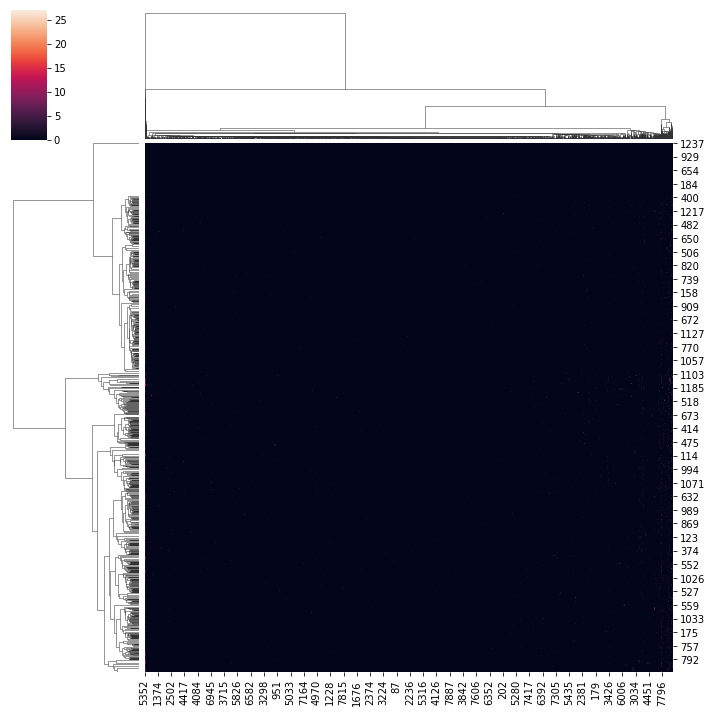

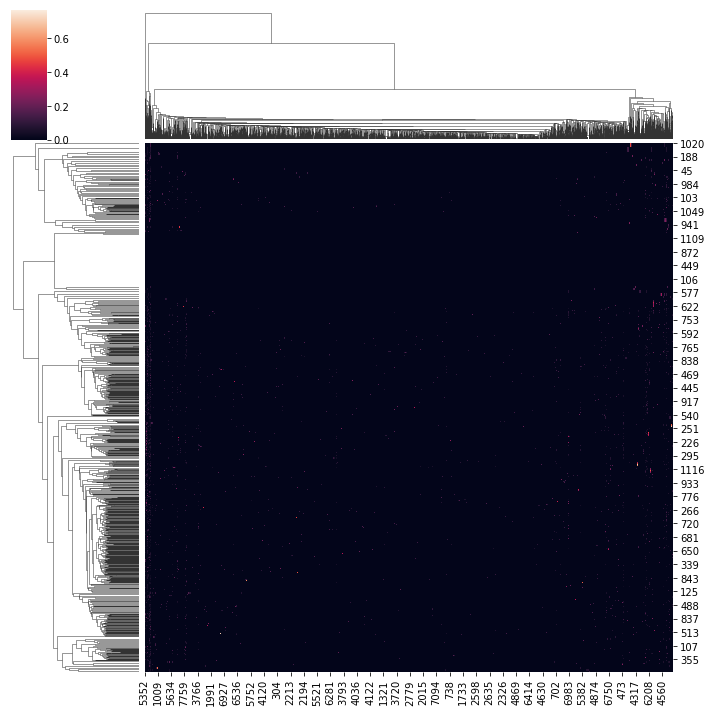

In [15]:
"""
insert code here that
1. retrieves the terms for all the assays that are relevant to the target the user picked.
2. clusters the assays according to their descriptive terms
3. plots the clusters (set n_clusters = 10)
4. prints out the title of one assay from each cluster.
"""

config = dotenv_values("database_url.env")
url = config['DATABASE_URL']
engine = create_engine(url, echo=False)

with engine.begin() as conn:
    query = text("select * from target_to_compounds;")
    target_list = pd.read_sql(query, conn)
display(target_list)


three_col_list = target_list[['assay_id', 'assay_description', 'abstract']].copy()

unique_list = []
for index, row in three_col_list.iterrows():
    if (row["assay_id"], row["assay_description"], row["abstract"]) in unique_list:
        continue
    else:
        unique_list.append((row["assay_id"], row["assay_description"], row["abstract"]))

Assay_Descriptions = [abstract for (assay_ids, assay_name, abstract) in unique_list]
Assay_Descriptions_Joined = ':: '.join(Assay_Descriptions)

print(len(unique_list))
#print(unique_list)
#print(Assay_Descriptions)


Assay_Descriptions_List = Assay_Descriptions


Assay_Count_Vect = CountVectorizer()
Assay_Train_Counts = Assay_Count_Vect.fit_transform(Assay_Descriptions_List)
n_clusters = 10
X = Assay_Train_Counts.toarray()

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(Assay_Train_Counts)
tf_idf_vector = tfidf_transformer.transform(Assay_Train_Counts)


ward = AgglomerativeClustering(
    n_clusters = n_clusters, linkage="ward", connectivity=None, compute_full_tree= True,compute_distances= True
)
ward.fit(X)



unique_labels, counts = np.unique(ward.labels_, return_counts=True)
cluster_sizes = dict(zip(unique_labels, counts))

largest_cluster_label = max(cluster_sizes, key=cluster_sizes.get)
largest_cluster_size = cluster_sizes[largest_cluster_label]

print(f"largest cluster: Cluster {largest_cluster_label}, Size: {largest_cluster_size}")

cluster_labels = ward.fit_predict(tf_idf_vector.toarray())



cluster_assay_descriptions = {}
for cluster_label, assay_description in zip(cluster_labels, Assay_Descriptions):
    if cluster_label not in cluster_assay_descriptions:
        cluster_assay_descriptions[cluster_label] = []
    cluster_assay_descriptions[cluster_label].append(assay_description)
    


sorted_clusters = sorted(cluster_assay_descriptions.keys())

for cluster_label in sorted_clusters:
    assay_descriptions = cluster_assay_descriptions[cluster_label]
    print(f"Cluster {cluster_label}: {assay_descriptions[0]}")

print(ward.distances_)
print(ward.distances_.shape)

X_Hist = ward.distances_
kernel = stats.gaussian_kde(X_Hist)
print(kernel(X_Hist))

seaborn.clustermap(X,method='ward')


df_idf = pd.DataFrame(tfidf_transformer.idf_,index=Assay_Count_Vect.get_feature_names_out(),columns=["idf_weights"])
df_idf.sort_values(by=['idf_weights'])

count_vector=Assay_Count_Vect.transform(Assay_Descriptions_List)


tf_idf_vector=tfidf_transformer.transform(count_vector)
print(tf_idf_vector)
tf_idf_vector.shape

feature_names = Assay_Count_Vect.get_feature_names_out()

first_document_vector=tf_idf_vector[0]


df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

seaborn.clustermap(tf_idf_vector.toarray(),method='ward')





"""
tagger = Classifier.load('hunflair')
print("Finished setting tagger")

Assay_Descriptions_List = []

sentence = Sentence(Assay_Descriptions_Joined)
tagger.predict(sentence)

Assay_Key_Words = ""
for label in sentence.get_labels():
    Assay_Key_Words += label.data_point.text
    Assay_Key_Words += " "
    #print(label.data_point.text)
    #print(Assay_Key_Words)

#adds the Descriptions of the Assays to the Assay Description List
Assay_Descriptions_List.append(Assay_Key_Words)

def tokenize_with_flair(description):
    sentence = Sentence(description)
    tagger.predict(sentence)
    return [ l.data_point.text for l in sentence.get_labels() ]



Assay_Count_Vect = CountVectorizer(tokenizer=tokenize_with_flair)
Assay_Train_Counts = Assay_Count_Vect.fit_transform(Assay_Descriptions_List)

n_clusters = 10  # number of regions
X = Assay_Train_Counts.toarray()

ward = AgglomerativeClustering(
    n_clusters = n_clusters, linkage="ward", connectivity=None, compute_full_tree= True,compute_distances= True
)
ward.fit(X)

print(ward.distances_)
print(ward.distances_.shape)

X_Hist = ward.distances_
#hist(X_Hist)
kernel = stats.gaussian_kde(X_Hist)
print(kernel(X_Hist))

#first dendogram
seaborn.clustermap(X,method='ward')

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(Assay_Train_Counts)


# print idf values
df_idf = pd.DataFrame(tfidf_transformer.idf_,index=Assay_Count_Vect.get_feature_names(),columns=["idf_weights"])

# sort ascending
df_idf.sort_values(by=['idf_weights'])

# count matrix
count_vector=Assay_Count_Vect.transform(Assay_Descriptions_List)

# tf-idf scores
tf_idf_vector=tfidf_transformer.transform(count_vector)
print(tf_idf_vector)
tf_idf_vector.shape

feature_names = Assay_Count_Vect.get_feature_names()

#get tfidf vector for first document
first_document_vector=tf_idf_vector[0]

#print the scores
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)


#second dendogram
seaborn.clustermap(tf_idf_vector.toarray(),method='ward')
"""